# About
Replication of Chapter 10 plots of S&P500 returns.

In [1]:
import numpy as np
import pandas as pd

# Helper Function

In [2]:
def get_SP500_daily_returns(data_source, log_returns=False):
    """Load time series of SP500 daily returns from finance.yahoo.com
    
    Parameters
    ----------
    data_source : str
        URL or path to csv file.
    log_returns : bool
        False returns the return ratio minus one.
            e.g. 0.20 for a 20% gain, -0.80 for a 20% decline.
        True returns the natural log of the return ratio.

    
    Returns
    -------
    daily_return : Pandas Series
    """

    # Load Dataset
    price_data = pd.read_csv(data_source, index_col=0, parse_dates=True)
    
    # Select Closing Prices
    close_price = price_data.Close
    
    # Calculate Daily Return
    price_change_ratio = close_price / close_price.shift(1) 

    if log_returns:
        daily_return = np.log(price_change_ratio)
    else:
        daily_return = price_change_ratio - 1
    
    # Remove NaN value
    ## The first day has no prior day so return is NaN
    assert daily_return.isna().sum() == 1  
    daily_return.dropna(inplace=True)

    return daily_return

# Fetch S&P 500 Returns

Calculate the historic daily returns. For context, a value of 0.01 indicates a 1% increase in value on the specified day.

In [3]:
# Calculate Returns
# This particular link captures 60 years from 1960 to 2019 end.
data_source = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-315619200&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'

In [4]:
daily_returns = get_SP500_daily_returns(data_source)
daily_returns

Date
1960-01-05    0.008012
1960-01-06   -0.004305
1960-01-07   -0.007318
1960-01-08   -0.003183
1960-01-11   -0.012269
                ...   
2019-12-24   -0.000195
2019-12-26    0.005128
2019-12-27    0.000034
2019-12-30   -0.005781
2019-12-31    0.002946
Name: Close, Length: 15101, dtype: float64

In [5]:
log_returns = get_SP500_daily_returns(data_source, log_returns=True)
log_returns

Date
1960-01-05    0.007980
1960-01-06   -0.004315
1960-01-07   -0.007344
1960-01-08   -0.003188
1960-01-11   -0.012345
                ...   
2019-12-24   -0.000195
2019-12-26    0.005115
2019-12-27    0.000034
2019-12-30   -0.005798
2019-12-31    0.002942
Name: Close, Length: 15101, dtype: float64

In [6]:
# Save data to file
#daily_returns.to_csv('NB37_daily_returns.csv')

# Figure 10.1 Log-Log Survival Probability

In [7]:
import fattails

In [8]:
sr = 100*daily_returns.abs()

In [9]:
sr.rename('daily_return', inplace=True)
df = sr.to_frame()

In [10]:
# Calculate survival probability for each datapoint
df['survival_probability'] = fattails.metrics.get_survival_probability(df.daily_return)
df = df.sort_values(by='daily_return') # show sorted values
df

,daily_return,survival_probability
Date,,
1960-07-19,0.000000,0.999934
1979-08-29,0.000000,0.999868
1976-04-29,0.000000,0.999801
1976-03-26,0.000000,0.999735
1985-03-28,0.000000,0.999669
...,...,...
2008-10-15,9.034978,0.000331
1987-10-21,9.099355,0.000265
2008-10-28,10.789006,0.000199


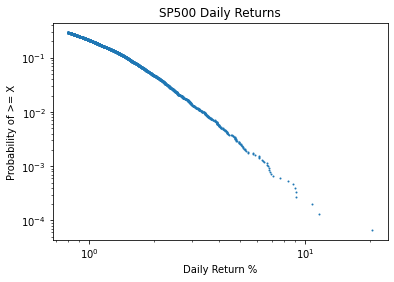

In [11]:
# Plot the Right Tail
selection = df.daily_return > 0.8 

right_tail = df.loc[selection]

right_tail.plot(x='daily_return', y='survival_probability',
                xlabel='Daily Return %', ylabel='Probability of >= X', 
                title='SP500 Daily Returns',
                kind='scatter', loglog=True,
                s=1); # xlabel argument requires pandas >= 1.2.0

# Figure 10.2 Convergence of Kurtosis
Kurtosis is a proxy for fat-tailedness.

In [12]:
df = log_returns.rename('log_return').to_frame()
df

,log_return
Date,
1960-01-05,0.007980
1960-01-06,-0.004315
1960-01-07,-0.007344
1960-01-08,-0.003188
1960-01-11,-0.012345
...,...
2019-12-24,-0.000195
2019-12-26,0.005115
2019-12-27,0.000034


In [13]:
kurtosis_df = pd.DataFrame({'window_size':range(1,100+1)})
kurtosis_df.head()

,window_size
0,1
1,2
2,3
3,4
4,5


In [14]:
from scipy.stats import kurtosis

def grouped_kurtosis(df, window_size):
    """ Calculate the kurtosis of log returns for different lags."""

    df = df.copy()

    df['window_number'] = np.arange(0, len(df)) // window_size

    kurt = df.groupby(df.window_number).sum().apply(kurtosis, fisher=False)
    
    return kurt

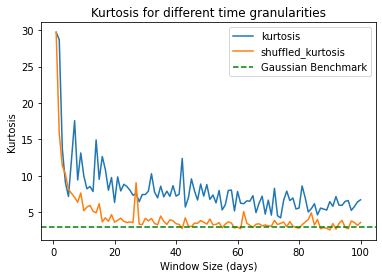

In [15]:
kurtosis_df['kurtosis'] = kurtosis_df.window_size.apply(lambda window_size: grouped_kurtosis(df, window_size))

kurtosis_df['shuffled_kurtosis'] = kurtosis_df.window_size.apply(lambda window_size: grouped_kurtosis(df.sample(frac=1), window_size))

trace_columns = ['kurtosis', 'shuffled_kurtosis']

ax = kurtosis_df.plot(x='window_size', y=trace_columns,
                  xlabel='Window Size (days)', ylabel='Kurtosis',
                  title='Kurtosis for different time granularities');

ax.axhline(3, color='g', linestyle='--', label='Gaussian Benchmark');

ax.legend();

# Drawdown Plots

### Figure 10.9

##### Define a `largest_drawdown` function

In [16]:
sr = pd.Series([0, 10, 5, 1000, 900])

In [17]:
def largest_drawdown(sr):
    """Calculate the greatest drop between a given value and the smallest value after it."""
    
    # Smallest value after each value (inclusive)
    reverse_cummin = sr[::-1].cummin()[::-1]
    
    # Largest drop possible (>=0)
    largest_drawdown = max(sr - reverse_cummin)
    
    return largest_drawdown

In [18]:
largest_drawdown(sr)

100

##### Analyse Drawdowns

In [19]:
df = daily_returns.rename('daily_return').to_frame()
df

,daily_return
Date,
1960-01-05,0.008012
1960-01-06,-0.004305
1960-01-07,-0.007318
1960-01-08,-0.003183
1960-01-11,-0.012269
...,...
2019-12-24,-0.000195
2019-12-26,0.005128
2019-12-27,0.000034


In [20]:
window_df = pd.DataFrame({'window_size':range(1,100+1)})
window_df.head()

,window_size
0,1
1,2
2,3
3,4
4,5


In [21]:
def apply_to_grouped_rows(sr, window_size, func):
    """ Apply func to groups of every n rows."""

    sr = sr.copy()
    
    # Get Series Name
    if not sr.name:
        sr.rename('input_sr', inplace=True)

    input_name = sr.name
    
    df = sr.to_frame()

    df['window_number'] = np.arange(0, len(df)) // window_size

    output = df[input_name].groupby(df.window_number).apply(func)
    
    return output

In [22]:
window_size=252

drawdown_sr = apply_to_grouped_rows(df.daily_return, window_size, func=largest_drawdown)
drawdown_sr

window_number
0     0.043271
1     0.070914
2     0.085615
3     0.046120
4     0.021465
5     0.033362
6     0.042917
7     0.036074
8     0.039894
9     0.035096
10    0.074754
11    0.047258
12    0.026847
13    0.060015
14    0.082672
15    0.044778
16    0.033597
17    0.034120
18    0.059547
19    0.050173
20    0.061889
21    0.053796
22    0.087244
23    0.044361
24    0.038778
25    0.045646
26    0.070638
27    0.233522
28    0.070561
29    0.083619
30    0.058609
31    0.065998
32    0.032380
33    0.039065
34    0.039262
35    0.036755
36    0.047429
37    0.099909
38    0.089426
39    0.073611
40    0.105924
41    0.092896
42    0.098863
43    0.070658
44    0.032686
45    0.038063
46    0.035120
47    0.058578
48    0.206150
49    0.113547
50    0.082950
51    0.092001
52    0.048625
53    0.042706
54    0.042293
55    0.068610
56    0.060680
57    0.031852
58    0.074350
59    0.051210
Name: daily_return, dtype: float64

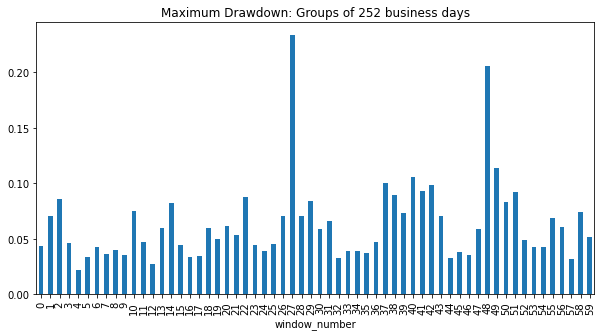

In [23]:
drawdown_sr.plot(kind='bar', figsize=(10, 5),
                 title=f'Maximum Drawdown: Groups of {window_size} business days');

In [24]:
sr = df.daily_return

drawdown_dict = {}
for window_size in [5, 30, 100, 252]:
    
    drawdown_dict[window_size] = apply_to_grouped_rows(sr, window_size, largest_drawdown)
    
drawdown_df = pd.DataFrame(drawdown_dict)
drawdown_df.columns.name = 'window_size'
drawdown_df

window_size,5,30,100,252
window_number,,,,
0,0.020281,0.027158,0.032882,0.043271
1,0.013903,0.029095,0.039907,0.070914
2,0.013428,0.032882,0.029436,0.085615
3,0.011811,0.017609,0.070914,0.046120
4,0.027158,0.026050,0.027556,0.021465
...,...,...,...,...
3016,0.004823,NaN,NaN,NaN
3017,0.008503,NaN,NaN,NaN
3018,0.007580,NaN,NaN,NaN


In [25]:
drawdown_df.max()

window_size
5      0.206150
30     0.233522
100    0.233522
252    0.233522
dtype: float64

In [26]:
import matplotlib.pyplot as plt

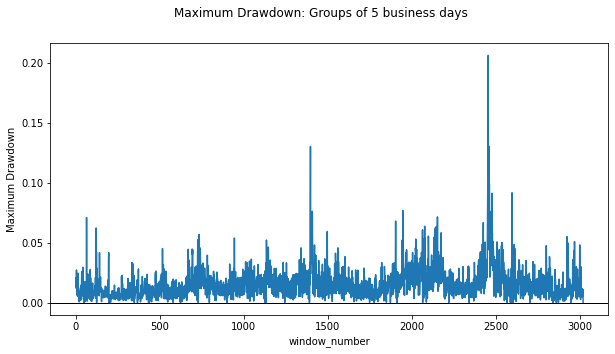

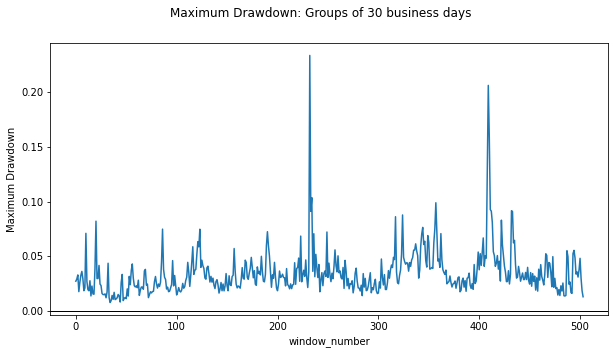

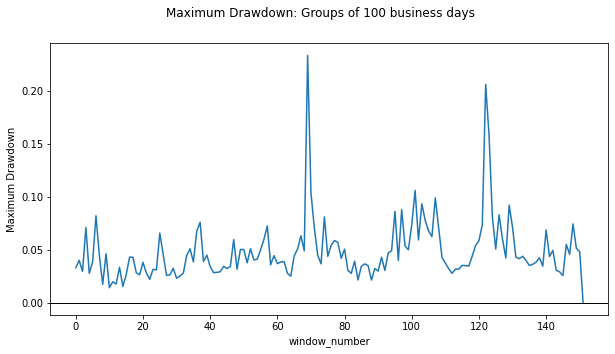

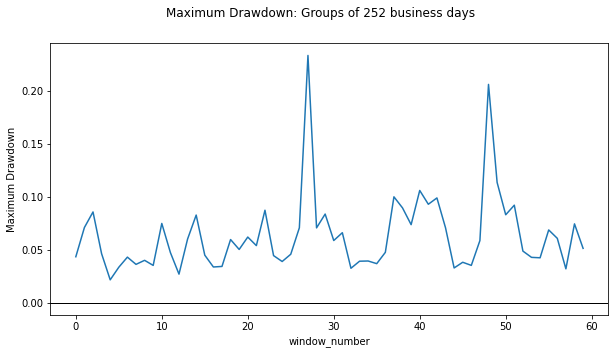

In [27]:
for col in drawdown_df.columns:
        
    ax = drawdown_df[col].dropna() \
                         .plot(subplots=True,
                               figsize=(10, 5),
                               ylabel='Maximum Drawdown',
                               title=f'Maximum Drawdown: Groups of {col} business days')
    
    ax[0].axhline(0, color='k', linewidth=1)
    plt.show()

# Figure 10.8 Empirical Kappa

In [28]:
sr = daily_returns.copy()
sr

Date
1960-01-05    0.008012
1960-01-06   -0.004305
1960-01-07   -0.007318
1960-01-08   -0.003183
1960-01-11   -0.012269
                ...   
2019-12-24   -0.000195
2019-12-26    0.005128
2019-12-27    0.000034
2019-12-30   -0.005781
2019-12-31    0.002946
Name: Close, Length: 15101, dtype: float64

In [29]:
def mad(x):
    """Calculate Mean Absolute Deviation
    The average deviation from sample mean.
    Not to be confused with 'Median' Absolute Deviation.
    Parameters
    ----------
    x : array_like
        Input array or object that can be converted to an array.
    Returns
    -------
    mad : scalar
          Mean Absolute Deviation of x
    """

    mean = np.mean(x)

    deviation = x-mean

    absolute_deviation = np.abs(deviation)

    mad = np.mean(absolute_deviation)

    return mad

In [30]:
def kappa_calculation(sr, n):
    
    # Mean Deviations
    
    # Group every n rows and sum
    n0 = 1
    n0_sr = sr.copy()
    
    n_sr = apply_to_grouped_rows(sr, window_size=n, func=np.sum)
    
    mad_n0 = mad(n0_sr)
    mad_n  = mad(n_sr)

    # -----------------------
    # Kappa expression
    
    top = np.log(n/n0)
        
    bottom = np.log(mad_n/mad_n0)
    
    kappa = 2 - top/bottom
    
    return kappa

In [31]:
window_sizes = np.arange(20, 600+20, 20)
window_size = pd.Series(window_sizes, name='window_size')

In [32]:
kappa = window_size.apply(lambda x: kappa_calculation(sr, n=x)) \
                   .rename('kappa')
kappa.head()

0    0.046815
1    0.011580
2    0.031183
3    0.041221
4   -0.020589
Name: kappa, dtype: float64

In [33]:
kappa_df = kappa.to_frame() \
                .set_index(window_size)
kappa_df.head()

,kappa
window_size,
20,0.046815
40,0.011580
60,0.031183
80,0.041221
100,-0.020589


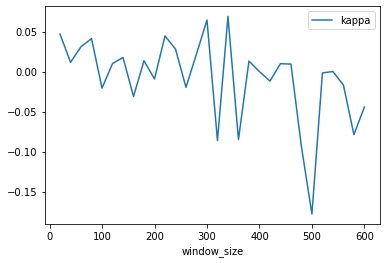

In [34]:
kappa_df.plot();

### Bootstrapped Kappa
Try estimate the expected kappa values for different window sizes.

This particular bootstrap method randomises the order so it loses any time structure.

In [35]:
def make_kappa_df(sr, window_sizes):
    
    kappa = window_size.apply(lambda x: kappa_calculation(sr, n=x)) \
                       .rename('kappa')
    
    kappa_df = kappa.to_frame() \
                    .set_index(window_size)
    
    return kappa_df

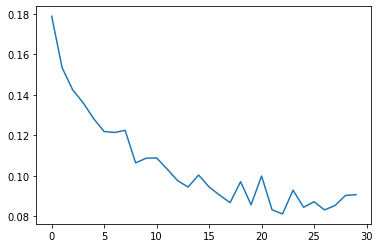

In [36]:
bootstrap_dict = {}
bootstrap_n = 100

for i in range(bootstrap_n):
    
    bootstrap_dict[i] = make_kappa_df(sr.sample(frac=1), window_sizes).kappa.values

bootstrap_df = pd.DataFrame(bootstrap_dict)#.mean(axis=1)
bootstrap_sr = bootstrap_df.mean(axis=1)
bootstrap_sr.plot();

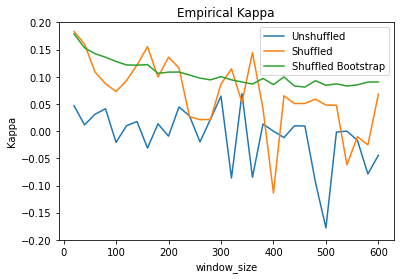

In [38]:
kappa_df.kappa.plot(label='Unshuffled', ylim=[-0.2, 0.2], 
                    title='Empirical Kappa',
                    ylabel='Kappa');

shuffled_df = make_kappa_df(sr.sample(frac=1), window_sizes)
shuffled_df.kappa.plot(label='Shuffled');

bootstrap_sr.index = kappa_df.index
bootstrap_sr.plot(label='Shuffled Bootstrap').legend();